In [ ]:
!pip install gluonts
!pip install autogluon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to 

In [ ]:
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.evaluation.metrics import mse
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short.csv')
df = df[df.unique_id == "BE"]
df

,unique_id,ds,y
0,BE,2016-10-22 00:00:00,70.00
1,BE,2016-10-22 01:00:00,37.10
2,BE,2016-10-22 02:00:00,37.10
3,BE,2016-10-22 03:00:00,44.75
4,BE,2016-10-22 04:00:00,37.10
...,...,...,...
1675,BE,2016-12-30 19:00:00,57.42
1676,BE,2016-12-30 20:00:00,57.56
1677,BE,2016-12-30 21:00:00,52.18
1678,BE,2016-12-30 22:00:00,54.38


In [ ]:
# Initialize variables
historical_days = 7
window_size = 24 * historical_days  # 24 hours a day
prediction_length = 24  # Predict 24 hours

pred_dict = {}
actual_dict = {}
best_model_name = []

# Iterate through the time series data by rolling window
for start_idx in range(len(df) - window_size):
    # Slice the data for the current rolling window
    rolling_window = df.iloc[start_idx : start_idx + window_size]

    # Convert rolling_window to a TimeSeriesDataFrame
    train_data = TimeSeriesDataFrame.from_data_frame(
        rolling_window,
        id_column='unique_id',  # Specify the item_id column
        timestamp_column='ds'  # Specify the timestamp column
    )

    # Fit the TimeSeriesPredictor on the rolling window
    predictor = TimeSeriesPredictor(
        prediction_length=prediction_length,
        path="multiple-timeseries/electric-hourly-1week_rollingwindow",
        freq="H",
        target="y",
        eval_metric="MSE",
    )
    predictor.fit(train_data, presets="fast_training", random_seed=42)

    # Predict the next hour
    prediction = predictor.predict(train_data, random_seed=42)

    # Add the predictions to the list
    pred_dict[df.iloc[start_idx + window_size].ds] = prediction['mean'].to_list()
    actual_dict[df.iloc[start_idx + window_size].ds] = df.iloc[start_idx + window_size].y

    best_model_name.append(predictor.info()["best_model"])

/usr/local/lib/python3.11/dist-packages/autogluon/timeseries/predictor.py:197: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  std_freq = pd.tseries.frequencies.to_offset(self.freq).freqstr
Frequency 'H' stored as 'h'
Beginning AutoGluon training...
AutoGluon will save models to '/content/multiple-timeseries/electric-hourly-1week_rollingwindow'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.86 GB / 12.67 GB (85.6%)
Disk Space Avail:   71.19 GB / 107.72 GB (66.1%)
Setting presets to: fast_training

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'freq': 'h',
 'hyperparameters': 'very_light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2

In [ ]:
# Assuming pred_dict is defined as in the original code
# Create an empty list to store the data for the DataFrame
data_pred = []

# Iterate through the pred_dict
for date, predictions in pred_dict.items():
  # Create a dictionary for each date's predictions
  row = {'time': date}
  for i, pred in enumerate(predictions):
    row[f'step{i+1}'] = pred
  data_pred.append(row)

# Create the DataFrame
pred_df = pd.DataFrame(data_pred)

# Create an empty list to store the data for the DataFrame
data_pred = []

# Iterate through the pred_dict
for time, predictions in pred_dict.items():
    row = {'time' : time}  # Start with the time as the first element
    for i in range(predictions.shape[1]):
        row[f'step{i+1}'] = predictions[:, i]  # Append each array of length  as separate column values
    data_pred.append(row)

# Create the DataFrame
pred_df = pd.DataFrame(data_pred)

actual_df = pd.DataFrame(list(actual_dict.items()), columns=['time', 'actual'])

# Convert 'time' column to datetime objects if they are not already
actual_df['time'] = pd.to_datetime(actual_df['time'])
pred_df['time'] = pd.to_datetime(pred_df['time'])

# Merge the DataFrames on the 'time' column
merged_df = pd.merge(actual_df, pred_df, on='time', how='inner')
merged_df['best_model'] = best_model_name
merged_df

NameError: name 'pred_dict' is not defined

In [ ]:
#merged_df.to_pickle('/content/drive/My Drive/autogluon_elec_BE_C1w_P1h_pred.pkl')

In [ ]:
import pandas as pd

#Predictions from Auto-gluon
pred_autogluon = pd.read_pickle('/content/drive/My Drive/autogluon_elec_BE_C1w_P1h_pred.pkl')
pred_autogluon.drop(columns = ['actual'], inplace = True)

#predictions from Lag-LLama model
pred_lagllama = pd.read_pickle('/content/drive/My Drive/lag_llama_elec_BE_C1w_P24h_pred.pkl')

In [ ]:
pred_lagllama.columns

Index(['time', 'actual', 'step1', 'step2', 'step3', 'step4', 'step5', 'step6',
       'step7', 'step8', 'step9', 'step10', 'step11', 'step12', 'step13',
       'step14', 'step15', 'step16', 'step17', 'step18', 'step19', 'step20',
       'step21', 'step22', 'step23', 'step24'],
      dtype='object')

In [ ]:
pred_autogluon.columns

Index(['time', 'step1', 'step2', 'step3', 'step4', 'step5', 'step6', 'step7',
       'step8', 'step9', 'step10', 'step11', 'step12', 'step13', 'step14',
       'step15', 'step16', 'step17', 'step18', 'step19', 'step20', 'step21',
       'step22', 'step23', 'step24', 'best_model'],
      dtype='object')

In [ ]:
pred_lagllama.isnull().values.any()

False

In [ ]:
pred_autogluon.isnull().values.any()

False

In [ ]:
# Merge the two dataframes
merged_df = pd.merge(pred_lagllama, pred_autogluon, on='time', suffixes=('_lagllama', '_autogluon'))

In [ ]:
from sklearn.metrics import mean_squared_error

# Initialize list to store the differences
mse_lagllama = []
mse_autogluon = []
mse_avg = []
mse_04l_06a = []
mse_025l_075a = []
mse_075l_025a = []
mse_max = []
mse_min = []

# Loop through the prediction steps (1 to 24)
for x in range(1, 25):
    # Calculate the differences
    temp = merged_df.copy()
    temp['actual_lag'] = merged_df['actual'].shift(-x+1)
    temp['avg'] = (merged_df[f'step{x}_lagllama'] + merged_df[f'step{x}_autogluon']) / 2
    temp['0.4l_0.6a'] = merged_df[f'step{x}_lagllama'] * 0.4 + merged_df[f'step{x}_autogluon'] * 0.6
    temp['0.25l_0.75a'] = merged_df[f'step{x}_lagllama'] * 0.25 + merged_df[f'step{x}_autogluon'] * 0.75
    temp['0.75l_0.25a'] = merged_df[f'step{x}_lagllama'] * 0.75 + merged_df[f'step{x}_autogluon'] * 0.25
    #temp_max = merged_df[[f'step{x}_lagllama', f'step{x}_autogluon']].max(axis=1)
    #temp_min = merged_df[[f'step{x}_lagllama', f'step{x}_autogluon']].min(axis=1)

    if x == 1:
      temp2 = temp
    else:
      temp2 = temp.iloc[:(-x+1)]

    mse_lagllama.append(mean_squared_error(temp2[f'step{x}_lagllama'], temp2['actual_lag']))
    mse_autogluon.append(mean_squared_error(temp2[f'step{x}_autogluon'], temp2['actual_lag']))
    mse_avg.append(mean_squared_error(temp2['avg'], temp2['actual_lag']))
    mse_04l_06a.append(mean_squared_error(temp2['0.4l_0.6a'], temp2['actual_lag']))
    mse_025l_075a.append(mean_squared_error(temp2['0.25l_0.75a'], temp2['actual_lag']))
    mse_075l_025a.append(mean_squared_error(temp2['0.75l_0.25a'], temp2['actual_lag']))

    """
    mse_lagllama.append(np.nanmean(merged_df[f'step{x}_lagllama'] - temp_actual_lag)**2)
    mse_autogluon.append(np.nanmean(merged_df[f'step{x}_autogluon'] - temp_actual_lag)**2)
    mse_avg.append(np.nanmean(temp_avg - temp_actual_lag)**2)
    mse_max.append(np.nanmean(temp_max - temp_actual_lag)**2)
    mse_min.append(np.nanmean(temp_min - temp_actual_lag)**2)
    """

print(f"MSE for LagLLama: {mse_lagllama}")
print(f"MSE for AutoGluon: {mse_autogluon}")
print(f"MSE for Average Difference: {mse_avg}")
#print(f"MSE for Max Difference: {mse_max}")
#print(f"MSE for Min Difference: {mse_min}")


MSE for LagLLama: [1288.7161865234375, 1432.2293701171875, 1561.7412109375, 1657.587158203125, 1693.3431396484375, 1697.9515380859375, 1714.0618896484375, 1725.7279052734375, 1749.310791015625, 1697.7796630859375, 1695.202392578125, 1686.8046875, 1679.2401123046875, 1653.5145263671875, 1635.6019287109375, 1628.619384765625, 1628.7327880859375, 1638.1876220703125, 1622.869873046875, 1610.2099609375, 1635.5927734375, 1612.4449462890625, 1632.0224609375, 1661.101806640625]
MSE for AutoGluon: [1074.5910414663583, 1361.2600385533076, 1468.4534551298998, 1490.6606301071893, 1439.2561791338303, 1406.1070747089148, 1481.7914002121895, 1489.3152993967335, 1494.3328901865323, 1509.4435142348375, 1483.4578039921037, 1543.6719969175442, 1571.193532910678, 1567.9477571000048, 1604.8461282921699, 1623.327851185015, 1627.7294466237047, 1633.3030885845399, 1601.350123517606, 1566.9056279903311, 1500.3476095333297, 1479.1660729233947, 1438.9711358193517, 1266.6705333066113]
MSE for Average Difference: 

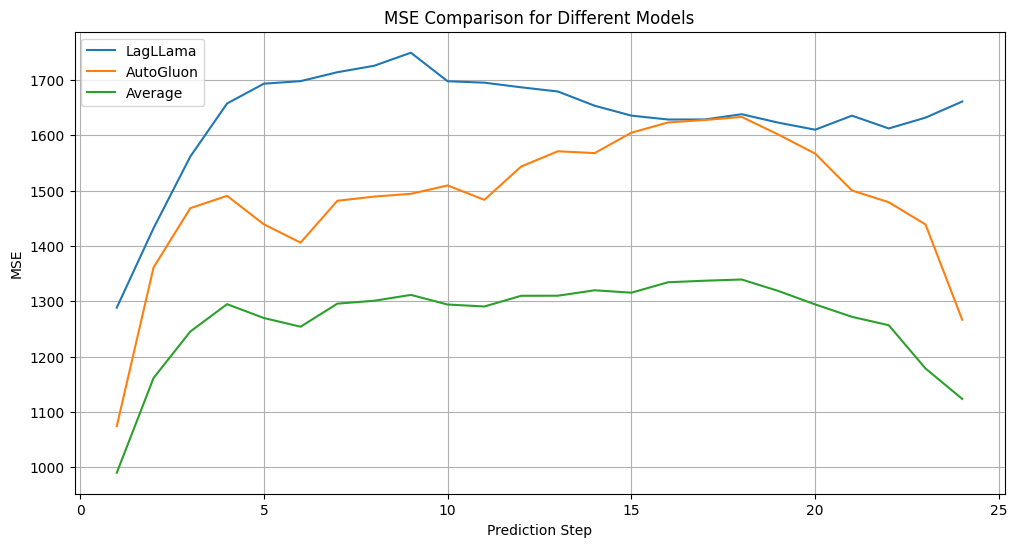

In [ ]:
# Assuming mse_lagllama, mse_autogluon, mse_avg, mse_max, and mse_min are defined as in the previous code
x_axis = list(range(1, 25))

plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(x_axis, mse_lagllama, label='LagLLama')
plt.plot(x_axis, mse_autogluon, label='AutoGluon')
plt.plot(x_axis, mse_avg, label='Average')

plt.xlabel('Prediction Step')
plt.ylabel('MSE')
plt.title('MSE Comparison for Different Models')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

mse_cv_min_step = []
mse_cv_max_step = []
mse_cv_avg_step = []
mse_train_step = []
mse_test_step = []
mse_overall_step = []
coeff_lagllama_step = []
coeff_autogluon_step = []

for x in range(1, 25):
  # Prepare the data for the regression model
  if x == 1:
    X = merged_df[[f'step{x}_lagllama', f'step{x}_autogluon']]
    y = merged_df['actual']
  else:
    X = merged_df[[f'step{x}_lagllama', f'step{x}_autogluon']].iloc[:(-x+1)]
    y = merged_df['actual'].shift(-x+1).iloc[:(-x+1)]

  # Split the data into training and testing sets
  X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False) # Important: shuffle=False to maintain time order

  # Define the time series cross-validation
  tscv = TimeSeriesSplit(n_splits=5)

  # Initialize lists to store results
  mse_scores = []

  # Perform cross-validation
  for train_index, val_index in tscv.split(X_cv):
      X_train, X_val = X_cv.iloc[train_index], X_cv.iloc[val_index]
      y_train, y_val = y_cv.iloc[train_index], y_cv.iloc[val_index]

      # Initialize and train the linear regression model
      model = LinearRegression(fit_intercept = False)
      model.fit(X_train, y_train)

      # Make predictions on the test set
      y_val_pred = model.predict(X_val)

      # Calculate MSE and store results
      mse = mean_squared_error(y_val, y_val_pred)
      mse_scores.append(mse)

  # Print the average MSE across all folds
  avg_mse = np.mean(mse_scores)
  min_mse = np.min(mse_scores)
  max_mse = np.max(mse_scores)
  mse_cv_avg_step.append(avg_mse)
  mse_cv_min_step.append(min_mse)
  mse_cv_max_step.append(max_mse)
  #print(f"Average MSE across folds: {avg_mse}")

  #train model on overall train data (cv)
  model = LinearRegression(fit_intercept = False)
  model.fit(X_cv, y_cv)

  coefficients = model.coef_
  coeff_lagllama_step.append(coefficients[0])
  coeff_autogluon_step.append(coefficients[1])

  #mse on overall data
  y_cv_pred = model.predict(X_cv)
  mse_train = mean_squared_error(y_cv, y_cv_pred)
  #print(f"MSE on overall train data: {mse_train}")
  mse_train_step.append(mse_train)

  #test the model on test data
  y_test_pred = model.predict(X_test)
  mse_test = mean_squared_error(y_test, y_test_pred)
  mse_test_step.append(mse_test)
  #print(f"MSE on test data: {mse_test}")

  #mse on complete data
  y_pred = model.predict(X)
  mse_overall = mean_squared_error(y, y_pred)
  mse_overall_step.append(mse_overall)
  #print(f"MSE on complete data: {mse_overall}")

In [ ]:
#print all the lists difened ending with _step

# Print all list defined ending with _step
print(f"mse_cv_avg_step: {mse_cv_avg_step}")
print(f"mse_train_step: {mse_train_step}")
print(f"mse_test_step: {mse_test_step}")
print(f"mse_overall_step: {mse_overall_step}")
print(f"coeff_lagllama_step: {coeff_lagllama_step}")
print(f"coeff_autogluon_step: {coeff_autogluon_step}")


mse_cv_avg_step: [np.float64(1647.844216231227), np.float64(2034.1379261702527), np.float64(2130.6081431813036), np.float64(2084.2793566843657), np.float64(1995.004121397436), np.float64(1940.6620575744855), np.float64(1985.8074045573435), np.float64(2039.3612589212375), np.float64(2021.0433491519652), np.float64(1984.8422396339151), np.float64(1960.818647228539), np.float64(2006.3477703718254), np.float64(2018.2475396205155), np.float64(2032.9084156945723), np.float64(2013.1465961350689), np.float64(2050.621352384917), np.float64(2030.6237764520952), np.float64(2020.101885549277), np.float64(1981.416705314874), np.float64(1926.7108796209475), np.float64(1883.835875214409), np.float64(1825.4845776671386), np.float64(1678.474586448434), np.float64(1567.5742784059562)]
mse_train_step: [1178.4347885950986, 1382.1525297738526, 1462.8158607651462, 1509.558823249288, 1473.8591899413268, 1454.4141362796129, 1510.8357462003821, 1516.7772833328424, 1529.1169502757973, 1519.1528567947182, 1516.4

In [ ]:
# prompt: create a dataframe having coeff of lagllama and autogluon

import pandas as pd
# Create a DataFrame from the lists
coeff_df = pd.DataFrame({
    'step': range(1, 25),
    'coeff_lagllama': coeff_lagllama_step,
    'coeff_autogluon': coeff_autogluon_step
})

coeff_df.to_pickle('/content/drive/My Drive/be_ensemble_coeff_1w.pkl')


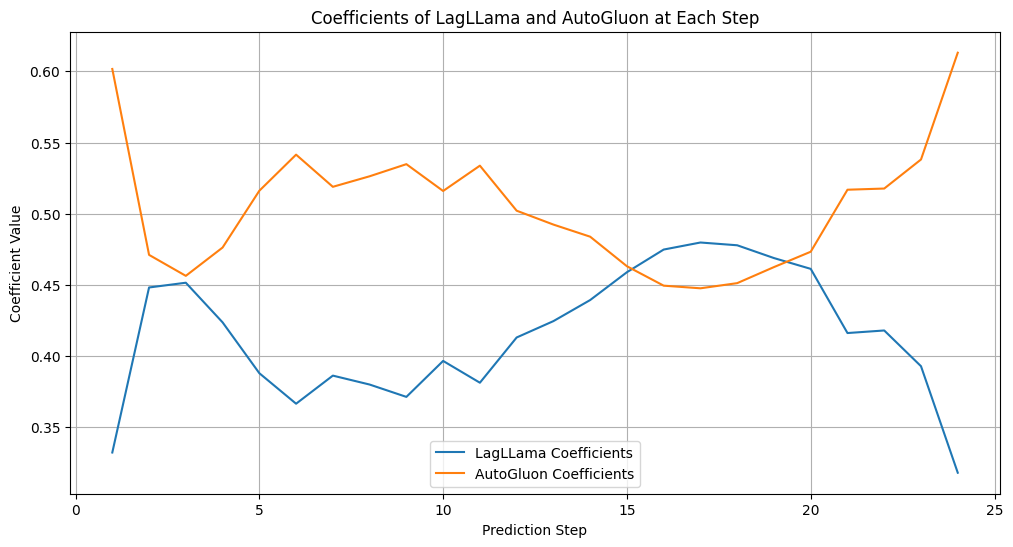

In [ ]:
#plot the co-efficients as line plot for lagllama and autogluon at each step
x_axis = list(range(1, 25))

plt.figure(figsize=(12, 6))
plt.plot(x_axis, coeff_lagllama_step, label='LagLLama Coefficients')
plt.plot(x_axis, coeff_autogluon_step, label='AutoGluon Coefficients')

plt.xlabel('Prediction Step')
plt.ylabel('Coefficient Value')
plt.title('Coefficients of LagLLama and AutoGluon at Each Step')
plt.legend()
plt.grid(True)
plt.show()


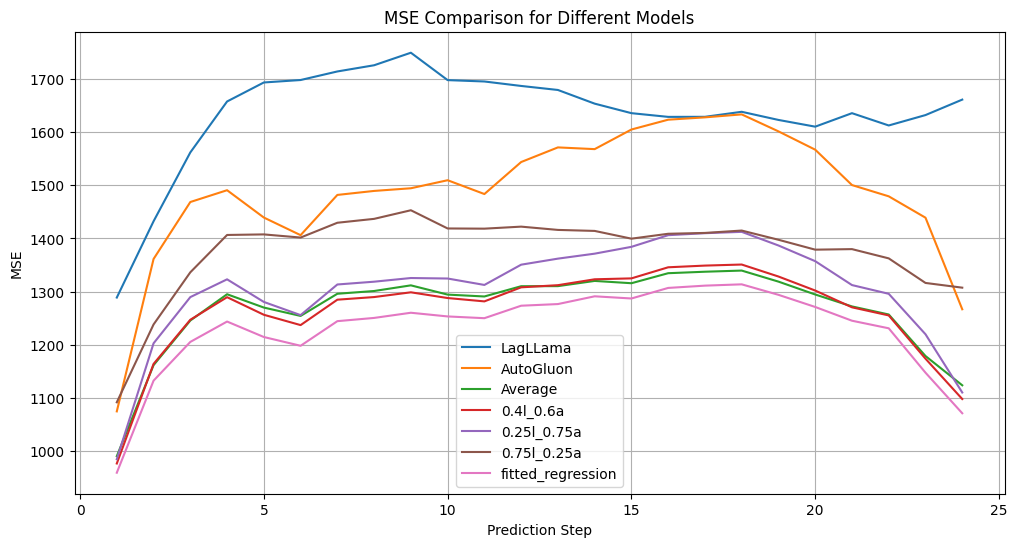

In [ ]:
#plot all the mse lists as a line chart with x-axis from 1 to 24.

import matplotlib.pyplot as plt

# Assuming mse_lagllama, mse_autogluon, mse_avg, mse_max, and mse_min are defined as in the previous code
x_axis = list(range(1, 25))

plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(x_axis, mse_lagllama, label='LagLLama')
plt.plot(x_axis, mse_autogluon, label='AutoGluon')
plt.plot(x_axis, mse_avg, label='Average')
plt.plot(x_axis, mse_04l_06a, label='0.4l_0.6a')
plt.plot(x_axis, mse_025l_075a, label='0.25l_0.75a')
plt.plot(x_axis, mse_075l_025a, label='0.75l_0.25a')
plt.plot(x_axis, mse_overall_step, label='fitted_regression')
#plt.plot(x_axis, mse_max, label='Max')
#plt.plot(x_axis, mse_min, label='Min')

plt.xlabel('Prediction Step')
plt.ylabel('MSE')
plt.title('MSE Comparison for Different Models')
plt.legend()
plt.grid(True)
plt.show()


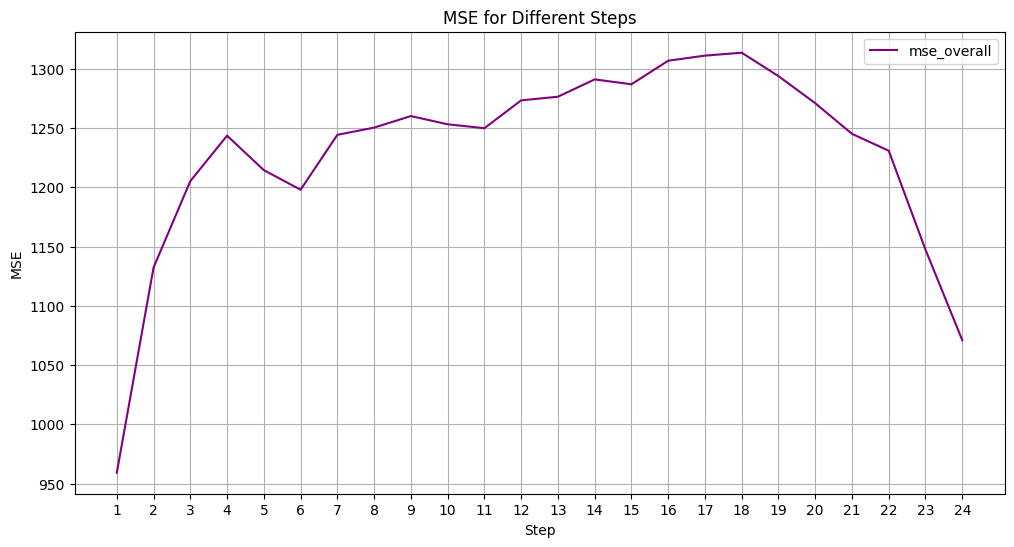

In [ ]:
# Create the plot
plt.figure(figsize=(12, 6))

#plt.fill_between(range(1,25), mse_cv_min_step, mse_cv_max_step, color='lightgreen', alpha=0.2)
#plt.plot(range(1, 25), mse_cv_avg_step, color='darkgreen', label='mse_cv_avg')
#plt.plot(range(1, 25), mse_train_step, color='olive', label='mse_train')
#plt.plot(range(1, 25), mse_test_step, color='red', label='mse_test')
plt.plot(range(1, 25), mse_overall_step, color='purple', label='mse_overall')

# Customize the plot
plt.xlabel('Step')
plt.ylabel('MSE')
plt.title('MSE for Different Steps')
plt.legend()
plt.grid(True)
plt.xticks(range(1, 25))
plt.show()
